In [17]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import List, Optional, Tuple


In [23]:
# dynamics of the pendulum
@dataclass
class Gaussian:
    mean: np.ndarray
    cov: np.ndarray
    cov_chol: np.ndarray


DT = 0.01
G = sp.constants.g


def xkp1(xk: np.ndarray) -> np.ndarray:
    xkp1 = np.zeros(2)
    xkp1[0] = xk[0] + xk[1]*DT
    xkp1[1] = xk[1] - G*np.sin(xk[0])*DT
    return xkp1


def get_q() -> np.ndarray:
    QC = 0.1
    return np.array([[QC*DT**3/3, QC*DT**2/2],
                     [QC*DT**2/2, QC*DT]])


def yk(xk: np.ndarray) -> np.ndarray:
    return np.sin(xk[0])

In [37]:
# setup the problem

@dataclass
class Observations:
    times: np.ndarray
    obs_ind: np.ndarray  # index of times that are observed
    obs: np.ndarray
    names: List[str]


def generate_truth(x0: np.ndarray, dt: float, N: int) -> Observations:
    times = np.zeros(N+1)  # from 0 to N times
    xk = np.zeros((N+1, 2))  # state at each time
    xk[0] = x0
    for i in range(1, N+1):
        times[i] = i*dt
        xk[i] = xkp1(xk[i-1])
    return Observations(times, range(N+1), xk, [r'$x_1$ true', r'$x_2$ true'])


def generate_obs(truth: Observations, delta: float, R: float) -> Observations:
    process_std = np.linalg.cholesky(get_q())
    measure_std = np.sqrt(R)
    measure_ind = np.arange(delta, truth.obs_ind[-1]+1, delta)
    obs = np.zeros(measure_ind.size)
    obs_ind = 0
    for i in measure_ind:
        obs[obs_ind] = yk(truth.obs[i] +
                          np.dot(process_std, np.random.randn(2))) + measure_std*np.random.randn()
        obs_ind += 1
    return Observations(truth.times, measure_ind, obs, [r'$x_1$ obs ($\delta$='+f'{delta};R={R})'])


N = 500
X0 = np.array([1.5, 0])
truth = generate_truth(X0, DT, N)
deltas = [5, 10, 20, 40]
Rs = [1, 0.1, 0.01, 0.001]
obs = []
for delta in deltas:
    for R in Rs:
        obs.append(generate_obs(truth, delta, R))

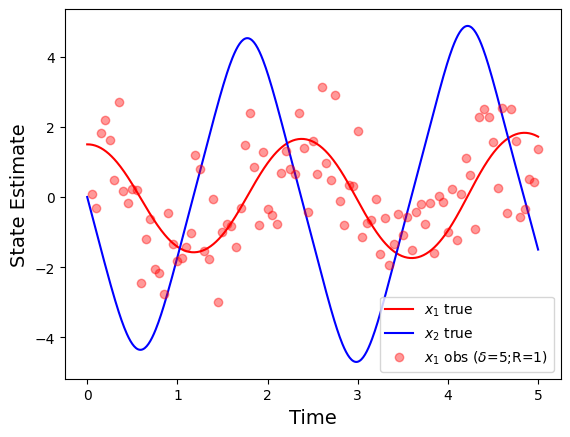

In [38]:
# setup helper functions


@dataclass
class KFTracker:
    means: np.ndarray
    covs: np.ndarray
    stds: np.ndarray


def plot_data_and_truth(fignum, true_obs: Observations, data_obs: Observations,
                        kft: Optional[KFTracker] = None) -> plt.figure:

    colors = ['red', 'blue', 'green']
    plt.close(fignum)
    fig = plt.figure(fignum)
    plt.plot(true_obs.times, true_obs.obs[:, 0], color=colors[0], label=true_obs.names[0])
    plt.plot(true_obs.times, true_obs.obs[:, 1], color=colors[1], label=true_obs.names[1])

    plt.plot(data_obs.times[data_obs.obs_ind], data_obs.obs,
             'o', color=colors[0], alpha=0.4, label=data_obs.names[0])

    if kft is not None:
        plt.plot(data_obs.times, kft.means[:, 0], '--', color=colors[0], label='est-state0')
        plt.plot(data_obs.times, kft.means[:, 1], '--', color=colors[1], label='est-state1')
        plt.fill_between(data_obs.times,
                         kft.means[:, 0] - 2 * kft.stds[:, 0],
                         kft.means[:, 0] + 2 * kft.stds[:, 0],
                         color=colors[0], alpha=0.3)
        plt.fill_between(data_obs.times,
                         kft.means[:, 1] - 2 * kft.stds[:, 1],
                         kft.means[:, 1] + 2 * kft.stds[:, 1],
                         color=colors[1], alpha=0.3)

    plt.legend()
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('State Estimate', fontsize=14)
    return fignum + 1


fignum = 1

fignum = plot_data_and_truth(fignum, truth, obs[0])

In [12]:
# extended kalman filter

def linear_prediction_step(A: np.ndarray, X: Gaussian, xi: Gaussian) -> Gaussian:
    """Linear Prediction Step: Propagate uncertainty for one time step.

    X_{k+1} = A X_{k} + xi, xi sim mathcal{N}{noise_mean, noise_cov}
    X_{k} sim mathcal{N}(mean, cov)

    Inputs
    ------
    A: (d, d) linear matrix
    X: Gaussian
    xi: Gaussian

    Returns
    -------
    A Gaussian random variable for the next time step
    """

    pred_mean = np.dot(A, X.mean) + xi.mean
    pred_cov = np.dot(A, np.dot(X.cov, A.T)) + xi.cov
    return Gaussian(pred_mean, pred_cov)


def linear_update_step(data: np.ndarray, H: np.ndarray, X: Gaussian, eta: Gaussian):
    """Linear Gaussian Inverse Problem.

    Inputs
    ------
    data: (N) array of data
    H: (N, d) linear model
    X: Gaussian
    eta: Gaussian

    Returns
    -------
    Gaussian Posterior
    """
    U = np.dot(X.cov, H.T)
    S = np.dot(H, U) + eta.cov
    mu = np.dot(H, X.mean) + eta.mean

    update_mean = X.mean + np.dot(U, np.linalg.solve(S, data - mu))
    update_cov = X.cov - np.dot(U, np.linalg.solve(S, U.T))
    return Gaussian(update_mean, update_cov)


def kalman_filter(data: Observations,
                  A: np.ndarray,
                  H: np.ndarray,
                  X: Gaussian,
                  xi: Gaussian, eta: Gaussian) -> Tuple[np.ndarray, np.ndarray]:
    """The Kalman filter.

    Inputs
    ------
    data: (N, m), N is the number of time steps, m is the size of the observations
    A: (d, d), dynamics
    H: (m, d), observation operator
    X: prior Gaussian
    xi: process noise
    eta: measurement noise

    Return
    ------
    KFTracker
    """

    num_steps = data.times.shape[0]

    d = X.mean.shape[0]
    mean_store = np.zeros((num_steps, d))
    mean_store[0, :] = np.copy(X.mean)
    cov_store = np.zeros((num_steps, d, d))
    cov_store[0, :, :] = np.copy(X.cov)

    std_store = np.zeros((num_steps, d))
    std_store[0, :] = np.sqrt(np.diag(cov_store[0, :, :]))

    # Loop over all time steps
    Xnext = X
    on_obs = 0
    for ii in range(1, num_steps):
        # Prediction
        Xpred = linear_prediction_step(A, Xnext, xi)

        # We have an observation so an update must occur
        if on_obs < data.obs_ind.shape[0] and ii == data.obs_ind[on_obs]:
            y = data.obs[on_obs]
            on_obs += 1

            # Update
            Xup = linear_update_step(y, H, Xpred, eta)
            Xnext = Xup

        else:
            Xnext = Xpred

        mean_store[ii, :] = np.copy(Xnext.mean)
        cov_store[ii, :, :] = np.copy(Xnext.cov)
        std_store[ii, :] = np.sqrt(np.diag(cov_store[ii, :, :]))

    return KFTracker(mean_store, cov_store, std_store)

# linearized dynamics


def Ak(xk: np.ndarray) -> np.ndarray:
    return np.array([[1, DT],
                     [-G*np.cos(xk[0])*DT, 1]])


def Hk(xk: np.ndarray) -> np.ndarray:
    return np.array([[np.cos(xk[0]), 0]])


prior = Gaussian(X0, np.eye(2), np.eye(2))